# 📓 California Housing: RF vs. AdaBoost vs. Bagged AdaBoost

**Objective:**  
- Compare three ensemble methods on the California Housing dataset  
- Understand how **sample weights** vs. **sampling** affect AdaBoost  
- Visualize and interpret results  
- Reflect on strengths, weaknesses, and when to apply each

## 1. Setup & Data Loading

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Fix randomness for reproducibility
np.random.seed(42)

# Load data
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 14448, Test samples: 6192


## Complete EDA

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14448 entries, 7061 to 15795
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      14448 non-null  float64
 1   HouseAge    14448 non-null  float64
 2   AveRooms    14448 non-null  float64
 3   AveBedrms   14448 non-null  float64
 4   Population  14448 non-null  float64
 5   AveOccup    14448 non-null  float64
 6   Latitude    14448 non-null  float64
 7   Longitude   14448 non-null  float64
dtypes: float64(8)
memory usage: 1015.9 KB


In [13]:
y_train.describe()

,MedHouseVal
count,14448.000000
mean,2.069240
std,1.157492
min,0.149990
25%,1.193000
50%,1.793000
75%,2.646000
max,5.000010


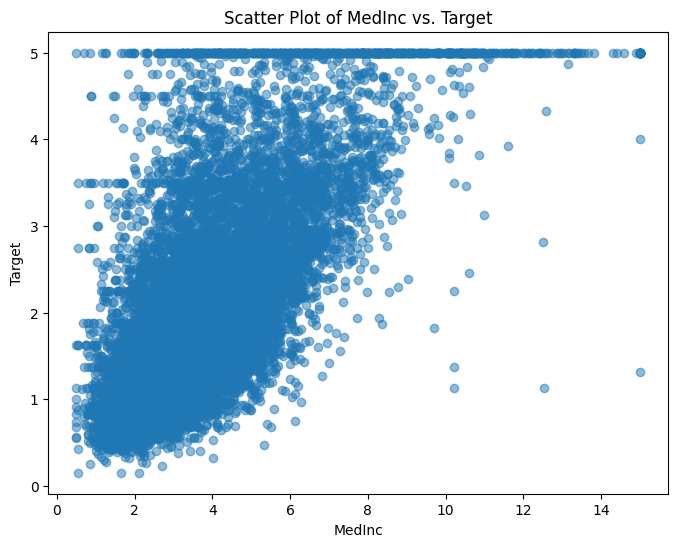

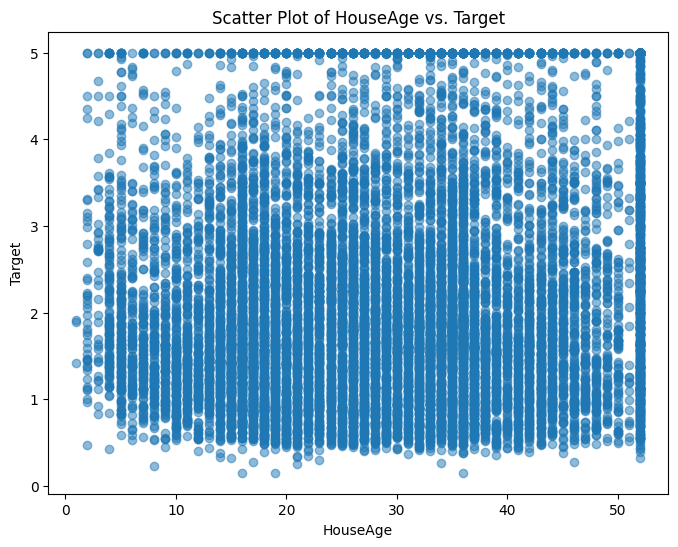

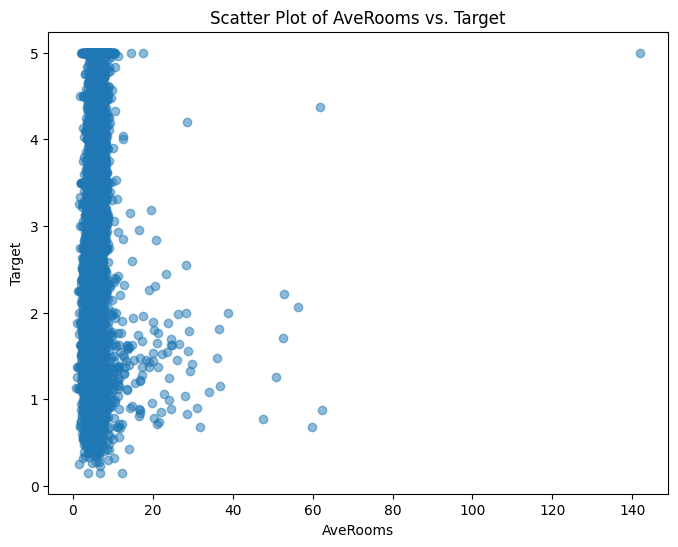

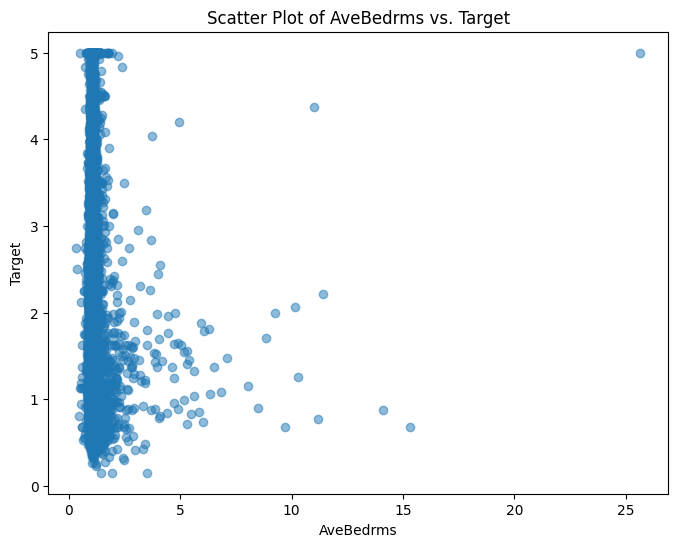

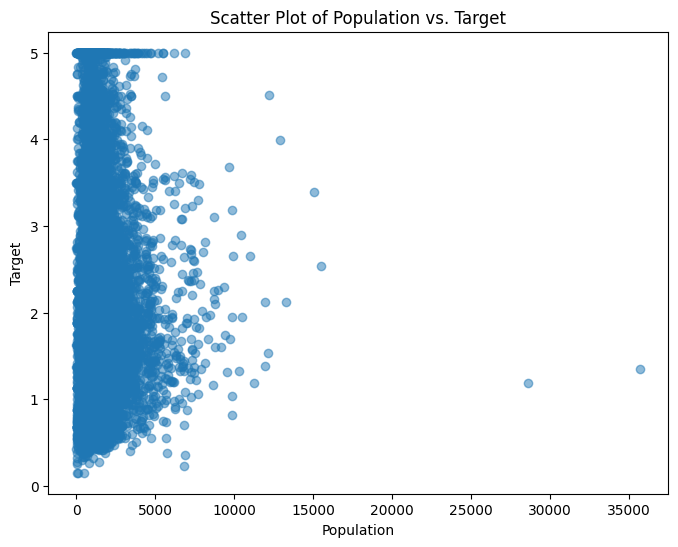

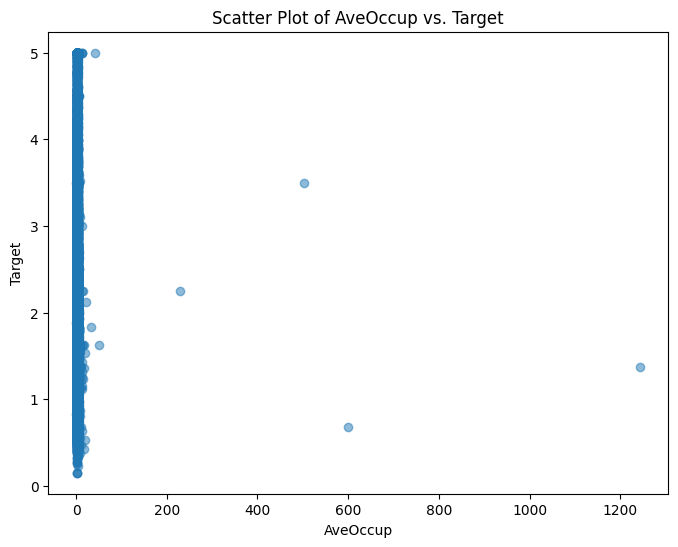

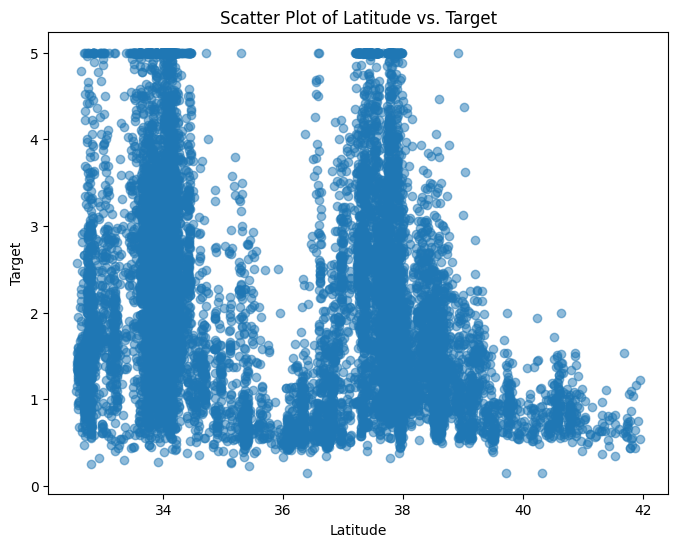

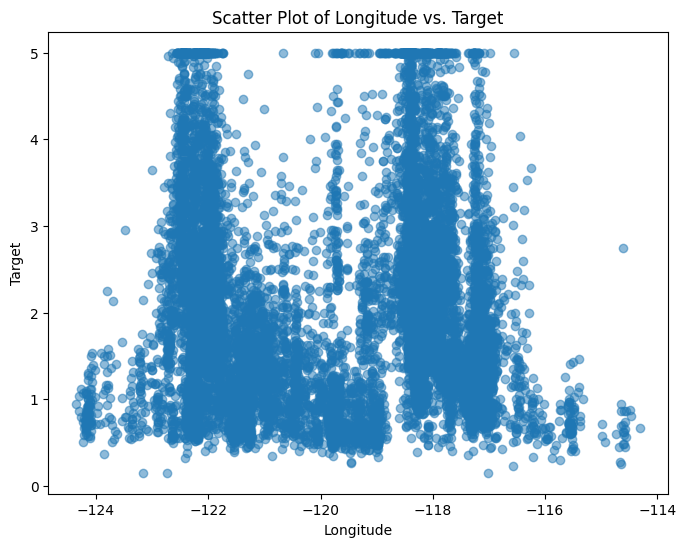

In [14]:
# Scatter plots of features vs. target
for col in X_train.columns:
  plt.figure(figsize=(8, 6))
  plt.scatter(X_train[col], y_train, alpha=0.5)
  plt.xlabel(col)
  plt.ylabel('Target')
  plt.title(f'Scatter Plot of {col} vs. Target')
  plt.show()

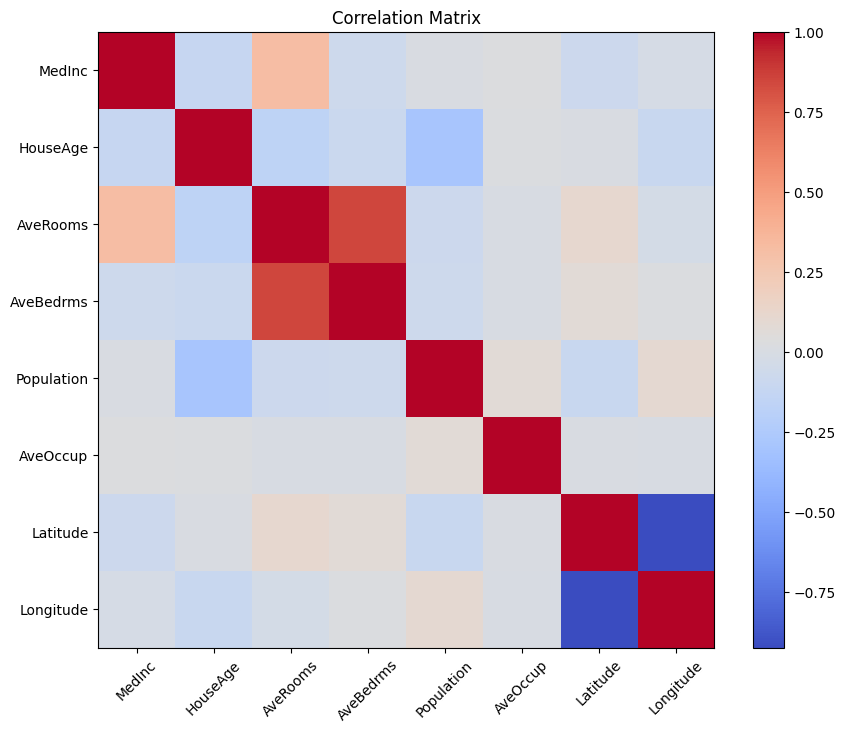

In [15]:
# Correlation matrix
corr_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

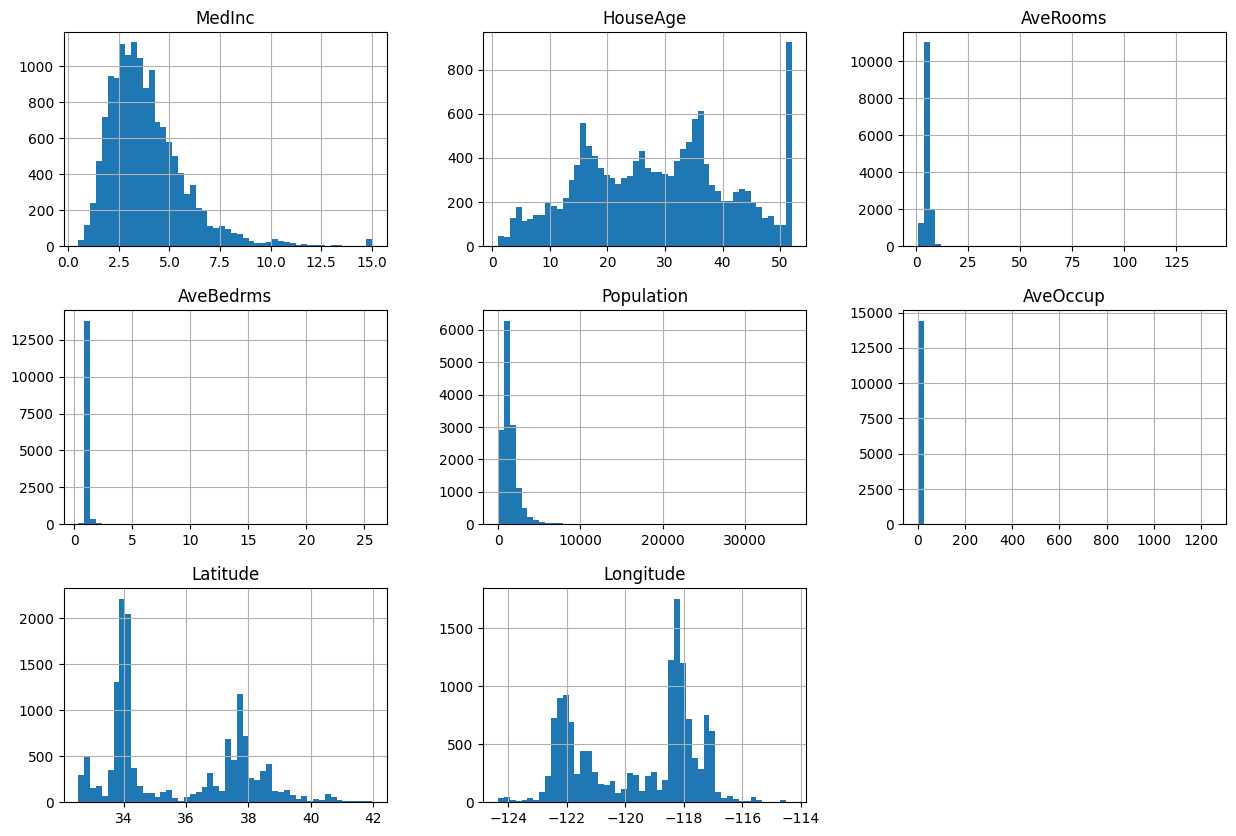

In [16]:
# Histograms of features
X_train.hist(bins=50, figsize=(15, 10))
plt.show()

---
## 2. Baseline: Random Forest Regressor

**Why?**  
Random Forests use bootstrap sampling + aggregation to reduce variance.  Serves as a strong off-the-shelf regressor.

In [17]:
# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=100, max_depth=6, random_state=42
)
rf.fit(X_train, y_train)

# Predictions & metrics
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf  = r2_score(y_test, y_pred_rf)

print(f"RF → RMSE: {np.sqrt(mse_rf):.3f},  R²: {r2_rf:.3f}")

RF → RMSE: 0.641,  R²: 0.687


**Interpretation:**  
- **RMSE** tells us average prediction error in house‑value units  
- **R²** measures explained variance (1.0 = perfect)  
- Inspect **feature importances** to see drivers of predictions

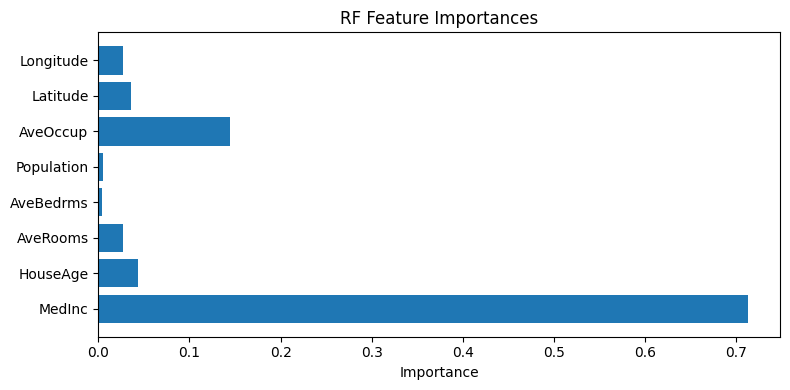

In [18]:
# Feature importances plot
importances = rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(8,4))
plt.barh(feat_names, importances)
plt.title("RF Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

---
## 3. AdaBoost Regressor (sklearn)

**How it works:**  
- Uses **all** data each round  
- Updates **sample weights** internally (requires base learner support)  
- Combines learners via a **weighted sum** of their predictions

In [19]:
# Train sklearn AdaBoost
ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=1),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)
mse_ada = mean_squared_error(y_test, y_pred_ada)
r2_ada  = r2_score(y_test, y_pred_ada)

print(f"AdaBoost → RMSE: {np.sqrt(mse_ada):.3f},  R²: {r2_ada:.3f}")

AdaBoost → RMSE: 0.965,  R²: 0.290


**Interpretation:**  
- Often reduces **bias** compared to a single tree  
- May be **more sensitive** to outliers than RF  

Plot the **learning curve** of train vs. test error:

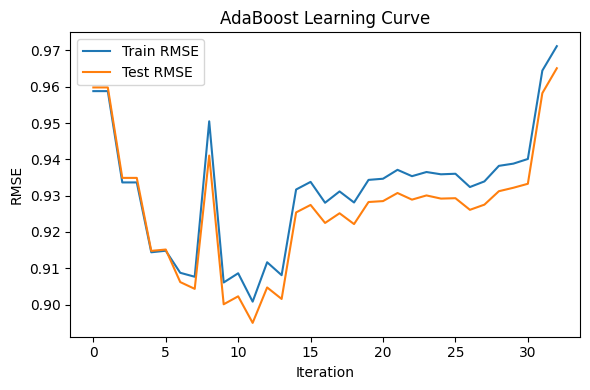

In [20]:
# Plot train/test error per iteration
train_err, test_err = [], []
for y_train_pred in ada.staged_predict(X_train):
    train_err.append(mean_squared_error(y_train, y_train_pred))
for y_test_pred in ada.staged_predict(X_test):
    test_err .append(mean_squared_error(y_test, y_test_pred))

plt.figure(figsize=(6,4))
plt.plot(np.sqrt(train_err), label="Train RMSE")
plt.plot(np.sqrt(test_err),  label="Test RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend()
plt.title("AdaBoost Learning Curve")
plt.tight_layout()
plt.show()

---
## 4. Custom “Bagged AdaBoost” (Sampling Variant)

**Goal:** mimic AdaBoost but use **sampling with replacement** at each round (prob ∝ sample weights).

In [21]:
# Custom Bagged AdaBoost for regression
from sklearn.base import clone

def bagged_adaboost_regressor(
    X, y, n_estimators=50, base_learner=DecisionTreeRegressor(max_depth=1)
):
    n = len(X)
    w = np.ones(n) / n            # initialize weights
    learners, alphas = [], []

    # Normalize y-range for loss scaling
    y_arr = np.array(y)
    R = np.max(np.abs(y_arr - np.mean(y_arr)))

    for m in range(n_estimators):
        # 1) Sample with replacement ∝ w
        idx = np.random.choice(n, size=n, replace=True, p=w)
        X_samp, y_samp = X.iloc[idx], y_arr[idx]

        # 2) Fit a new learner
        clf = clone(base_learner)
        clf.fit(X_samp, y_samp)

        # 3) Predict on full set, compute normalized loss
        y_pred_full = clf.predict(X)
        loss = np.abs(y_arr - y_pred_full) / R   # in [0,1]

        # 4) Weighted error
        err = np.dot(w, loss)
        if err >= 0.5:  # skip if no improvement
            continue

        # 5) Compute alpha
        alpha = 0.5 * np.log((1 - err) / err)
        learners.append(clf);  alphas.append(alpha)

        # 6) Update weights: upweight high-loss examples
        w *= np.exp(alpha * loss)
        w /= np.sum(w)  # normalize

    return learners, alphas

def predict_bagged_ada(X, learners, alphas):
    pred = np.zeros(len(X))
    for clf, a in zip(learners, alphas):
        pred += a * clf.predict(X)
    return pred / np.sum(alphas)

# Train + evaluate
learners, alphas = bagged_adaboost_regressor(X_train, y_train, n_estimators=50)
y_pred_bag = predict_bagged_ada(X_test, learners, alphas)

mse_bag = mean_squared_error(y_test, y_pred_bag)
r2_bag  = r2_score(y_test, y_pred_bag)
print(f"Bagged AdaBoost → RMSE: {np.sqrt(mse_bag):.3f},  R²: {r2_bag:.3f}")

Bagged AdaBoost → RMSE: 0.942,  R²: 0.323


**Interpretation:**  
- Sampling variant **emphasizes** hard examples by repeating them  
- Can be used when base learners **don’t support** sample weights  
- Compare its performance to sklearn’s AdaBoost and RF

             Model      RMSE        R²
0    Random Forest  0.640968  0.686989
1         AdaBoost  0.965103  0.290366
2  Bagged AdaBoost  0.942308  0.323492


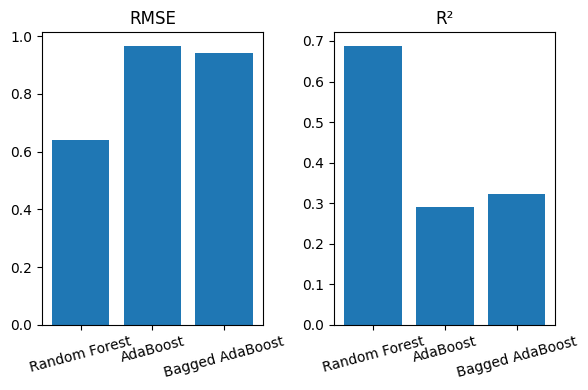

In [22]:
# Visual comparison of all three
results = pd.DataFrame({
    "Model": ["Random Forest", "AdaBoost", "Bagged AdaBoost"],
    "RMSE":   [np.sqrt(mse_rf), np.sqrt(mse_ada), np.sqrt(mse_bag)],
    "R²":     [r2_rf, r2_ada, r2_bag]
})
print(results)

# Bar chart
plt.figure(figsize=(6,4))
for i, col in enumerate(["RMSE","R²"]):
    plt.subplot(1,2,i+1)
    plt.bar(results["Model"], results[col])
    plt.xticks(rotation=15)
    plt.title(col)
plt.tight_layout()
plt.show()

## Extension Activity: Outlier Removal and Model Evaluation

Your task:

1. Identify potential outliers in the California Housing dataset:
   - Use plots like `hist()`, `boxplot()`, or `scatter()` of `y` (housing price).
   - Consider cutting off values above the 95th percentile of the target.

2. Remove or clip these outliers and retrain:
   - Re-run AdaBoost and Random Forest on the cleaned dataset.
   - Compare RMSE and R² before and after.

3. Reflect:
   - Did AdaBoost improve more than Random Forest?
   - What does this tell you about model sensitivity?

### Bonus:
Try increasing the base learner depth for AdaBoost after outlier removal. Does performance improve even more?


### Identify potential outliers


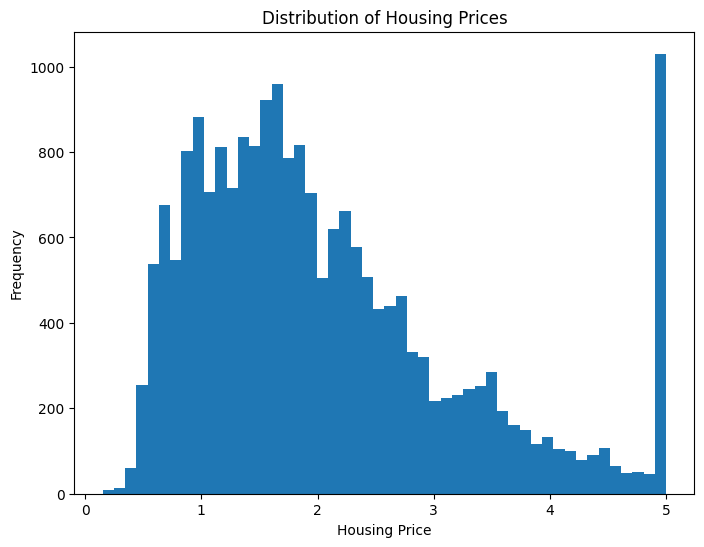

In [25]:
plt.figure(figsize=(8, 6))
plt.hist(y, bins=50)
plt.xlabel("Housing Price")
plt.ylabel("Frequency")
plt.title("Distribution of Housing Prices")
plt.show()

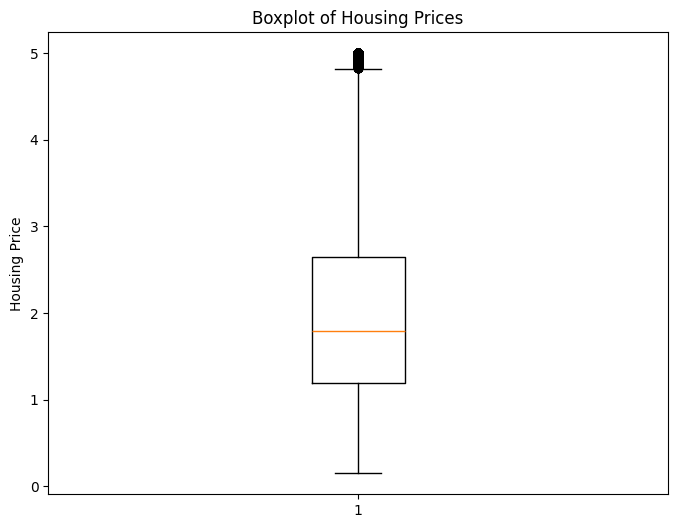

In [26]:
plt.figure(figsize=(8, 6))
plt.boxplot(y)
plt.ylabel("Housing Price")
plt.title("Boxplot of Housing Prices")
plt.show()

In [27]:
# Calculate the 95th percentile
threshold = np.percentile(y, 95)

# Filter out outliers
X_train_filtered = X_train[y_train <= threshold]
y_train_filtered = y_train[y_train <= threshold]

#Retrain the models with filtered data
#AdaBoost
ada_filtered = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=1),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
ada_filtered.fit(X_train_filtered, y_train_filtered)
y_pred_ada_filtered = ada_filtered.predict(X_test)
mse_ada_filtered = mean_squared_error(y_test, y_pred_ada_filtered)
r2_ada_filtered  = r2_score(y_test, y_pred_ada_filtered)
print(f"AdaBoost (filtered) → RMSE: {np.sqrt(mse_ada_filtered):.3f},  R²: {r2_ada_filtered:.3f}")

AdaBoost (filtered) → RMSE: 0.950,  R²: 0.312


In [28]:
#RandomForest
rf_filtered = RandomForestRegressor(
    n_estimators=100, max_depth=6, random_state=42
)
rf_filtered.fit(X_train_filtered, y_train_filtered)
y_pred_rf_filtered = rf_filtered.predict(X_test)
mse_rf_filtered = mean_squared_error(y_test, y_pred_rf_filtered)
r2_rf_filtered  = r2_score(y_test, y_pred_rf_filtered)
print(f"RF (filtered) → RMSE: {np.sqrt(mse_rf_filtered):.3f},  R²: {r2_rf_filtered:.3f}")

RF (filtered) → RMSE: 0.661,  R²: 0.667


In [29]:
# Comparison
print("\nModel Comparison Before and After Outlier Removal:")
print(f"{'Model':<15} {'RMSE (Before)':<15} {'R² (Before)':<15} {'RMSE (After)':<15} {'R² (After)':<15}")
print(f"{'AdaBoost':<15} {np.sqrt(mse_ada):<15.3f} {r2_ada:<15.3f} {np.sqrt(mse_ada_filtered):<15.3f} {r2_ada_filtered:<15.3f}")
print(f"{'RandomForest':<15} {np.sqrt(mse_rf):<15.3f} {r2_rf:<15.3f} {np.sqrt(mse_rf_filtered):<15.3f} {r2_rf_filtered:<15.3f}")



Model Comparison Before and After Outlier Removal:
Model           RMSE (Before)   R² (Before)     RMSE (After)    R² (After)     
AdaBoost        0.965           0.290           0.950           0.312          
RandomForest    0.641           0.687           0.661           0.667          


- AdaBoost RMSE Improvement: 0.015
- Random Forest RMSE Improvement: -0.020
- AdaBoost improved more than Random Forest.
- This suggests that AdaBoost might be more sensitive to outliers than Random Forest, as its performance significantly improved after outlier removal.